In [ ]:
!pip install -q transformers==4.20.0
!pip install -q pytorch-lightning
!pip install -q wandb
!pip install -q roboflow

ROBOFLOW_API_KEY = "KRWfPn04UCd6BFEwKTP1"
 #obtain an API Key from your roboflow workspace's settings & treat it like a password

In [ ]:
from huggingface_hub import login
from google.colab import userdata
token = userdata.get('Nyi_token')
login(token=token)

In [ ]:
#Register dataset as torchvision CocoDetection
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "_annotations.coco.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=512, max_size=864)

train_dataset = CocoDetection(img_folder=(dataset.location + '/train'), feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder=(dataset.location + '/valid'), feature_extractor=feature_extractor, train=False)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 225
Number of validation examples: 30


Image n°39


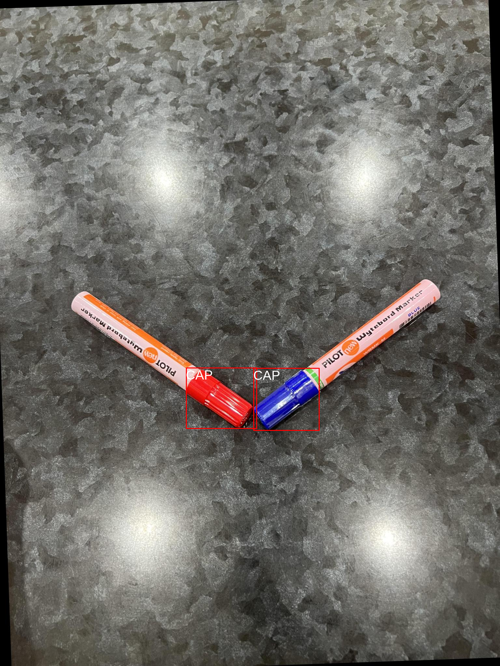

In [ ]:
#Vizualize that our data has loaded correctly - You can hit this cell as many times as you want to vizualize how your training set has loaded
import numpy as np
import os
from PIL import Image, ImageDraw, ImageFont

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(dataset.location + '/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

font_path = "/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf"

# Check if the font file exists, if not, download it
if not os.path.exists(font_path):
    print(f"Font not found at {font_path}. Downloading LiberationSans-Regular.ttf...")
    # Use a publicly available font or download one
    font_url = "https://github.com/googlefonts/liberation-fonts/raw/main/ttf/LiberationSans-Regular.ttf"
    try:
        response = requests.get(font_url)
        response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)
        # Create the directory if it doesn't exist
        os.makedirs(os.path.dirname(font_path), exist_ok=True)
        with open(font_path, 'wb') as f:
            f.write(response.content)
        print("Font downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading font: {e}")
        # Fallback to a potentially available default font if download fails
        font_path = "DejaVuSans.ttf"
        print(f"Falling back to default font: {font_path}")

# Load the font using the determined path
try:
    font = ImageFont.truetype(font_path, 40) # Increased font size for better visibility
except IOError:
    print(f"Could not load font from {font_path}. Please ensure a compatible font is available.")
    # If even the fallback fails, use a basic bitmap font
    font = ImageFont.load_default()

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=3)
  draw.text((x, y), id2label[class_idx], fill='white', font=font)

width, height = image.size
target_width = 500
ratio = target_width / width
target_height = int(height * ratio)

image.resize((target_width, target_height))

In [ ]:
#Setup dataloader for training loop

from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)
batch = next(iter(train_dataloader))

In [ ]:
# For our training configuration, we will start from the pretrained YOLOS-tiny model from
# Hugging Face transformers

import pytorch_lightning as pl
from transformers import DetrConfig, AutoModelForObjectDetection
import torch

#we wrap our model around pytorch lightning for training
class YoloS(pl.LightningModule):

     def __init__(self, lr, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-small",
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.weight_decay = weight_decay
         self.save_hyperparameters()  # adding this will save the hyperparameters to W&B too

     def forward(self, pixel_values):
       outputs = self.model(pixel_values=pixel_values)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("train/loss", loss)  # logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace
        for k,v in loss_dict.items():
          self.log("train/" + k, v.item())  # logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss) # logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace
        for k,v in loss_dict.items():
          self.log("validation/" + k, v.item()) #  logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace

        return loss

     def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [ ]:
#initialize the model
model = YoloS(lr=2.5e-5, weight_decay=1e-4)

In [ ]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# Name your wandb project and upload the final checkpoint to wandb, according to ModelCheckpoint
# Click on the output wandb run name below to see your metrics updating live in wandb
#wandb_logger = WandbLogger(project='roboflow-yolos', log_model=True)

# Keep track of the checkpoint with the lowest validation loss
checkpoint_callback = ModelCheckpoint(monitor="validation/loss", mode="min")

In [ ]:
from pytorch_lightning import Trainer

#more epochs leads to a tighter fit of your model to your data.
#we set epochs=10 here for an example of quick training
trainer = Trainer(accelerator='gpu', devices=1, max_epochs=10, gradient_clip_val=0.1, accumulate_grad_batches=8,
                  log_every_n_steps=5) #  , logger=wandb_logger, callbacks=[checkpoint_callback] ,checkpoint_callback to log model to W&B at end of training and changed log_every_n_steps=5 to generate better charts
trainer.fit(model)

In [ ]:
#clean up torch tensors before eval so your gpu memory doesn't crash!
torch.cuda.empty_cache()

In [ ]:
#we borrow the eval scripts from the DETR repo as they provide similar functionality to what we need to calculate mAP
!git clone https://github.com/facebookresearch/detr.git
%cd /content/detr

Cloning into 'detr'...
remote: Enumerating objects: 265, done.
remote: Total 265 (delta 0), reused 0 (delta 0), pack-reused 265 (from 1)
Receiving objects: 100% (265/265), 21.19 MiB | 20.30 MiB/s, done.
Resolving deltas: 100% (120/120), done.
/content/detr


In [ ]:
from datasets import get_coco_api_from_dataset

base_ds = get_coco_api_from_dataset(val_dataset) # this is actually just calling the coco attribute

In [ ]:
from datasets.coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    outputs = model.model(pixel_values=pixel_values)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs of model to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()
#the evaluation here prints out mean average precision details
#learn more - https://blog.roboflow.com/mean-average-precision/

In [ ]:
#We can use the image_id in target to know which image it is

pixel_values, target = val_dataset[1]
pixel_values = pixel_values.unsqueeze(0).to(device)
outputs = model(pixel_values=pixel_values)

In [ ]:
import torch
import matplotlib.pyplot as plt

#lower confidence yields more, but less accurate predictions
CONFIDENCE=0.5

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=2))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin+12, ymin-25, text, fontsize=10,
                bbox=dict(facecolor='white', alpha=0.5))
    plt.axis('off')
    plt.show()

def visualize_predictions(image, outputs, threshold=CONFIDENCE):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

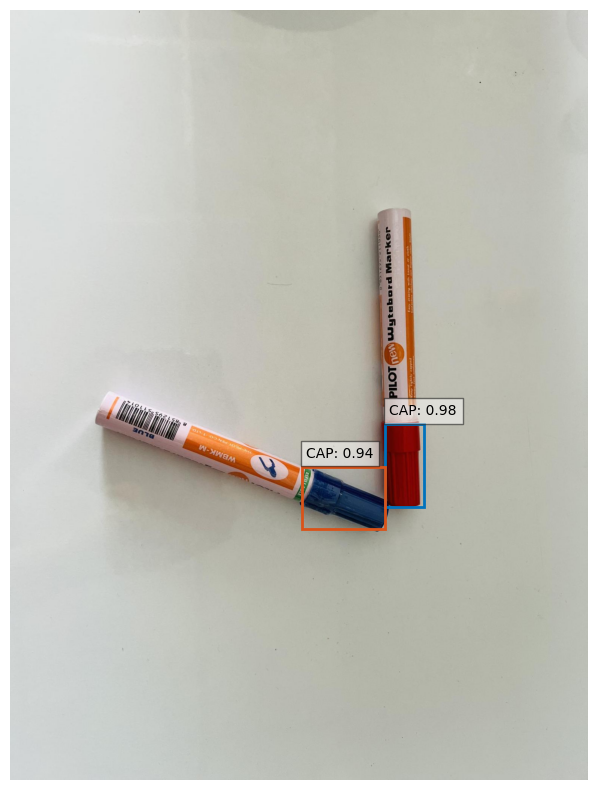

In [ ]:
image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(dataset.location + '/valid', image['file_name']))

visualize_predictions(image, outputs)